# Evaluate cancer subtype classification model  with Receiver Operating Characteristic (ROC) metric

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import label_binarize

from tqdm import tqdm

from pathway_forte.constants import *

In [3]:
subtype_path = os.path.join(DATA,'tcga_datasets','brca','brca_subtypes_matrix.txt')

kegg_ssgsea_path = os.path.join(KEGG_SSGSEA, 'kegg_brca.tsv')
wikipathways_ssgsea_path = os.path.join(WIKIPATHWAYS_SSGSEA, 'wikipathways_brca.tsv')
reactome_ssgsea_path = os.path.join(REACTOME_SSGSEA, 'reactome_brca.tsv')
merge_ssgsea_path = os.path.join(MERGE_SSGSEA, 'merge_brca.tsv')

brca_subtypes_df = pd.read_csv(subtype_path, sep='\t')
kegg_enrichment_score_df = pd.read_csv(kegg_ssgsea_path, sep='\t', header=0)
wikipathways_enrichment_score_df = pd.read_csv(wikipathways_ssgsea_path, sep='\t', header=0)
reactome_enrichment_score_df = pd.read_csv(reactome_ssgsea_path, sep='\t', header=0)
merge_enrichment_score_df = pd.read_csv(merge_ssgsea_path, sep='\t', header=0)

In [4]:
brca_subtypes_df.drop("barcode", axis=1, inplace=True)
brca_subtypes_df = brca_subtypes_df[brca_subtypes_df.subtype_BRCA_Subtype_PAM50 != 'Normal']
patient_ids = brca_subtypes_df.index

In [5]:
brca_subtypes_df.head()

,subtype_BRCA_Subtype_PAM50
TCGA-A8-A07C-01A-11R-A034-07,Basal
TCGA-E9-A5FL-01A-11R-A27Q-07,Basal
TCGA-BH-A18L-01A-32R-A12D-07,LumB
TCGA-EW-A1P3-01A-11R-A144-07,LumA
TCGA-A2-A0CM-01A-31R-A034-07,Basal


In [6]:
def stabilize_ssgsea_scores_df(df):
    
    # Transpose dataFrame to arrange columns as pathways and rows as genes
    df = df.transpose()

    # Set column index to the first row in the dataframe
    df.columns = df.iloc[0]

    # Remove the first row because it is already set as column index
    df = df.drop("Term|NES")
    
    return df

In [7]:
def convert_df_to_features_array(df):
    
    # Get list of pathways as features
    feature_cols = list(df.columns.values)

    # Features
    pathways = df[feature_cols]  # Features

    # Transform features dataFrame to numpy array
    # pathways_array = pathways.values
    
    return pathways

In [8]:
def match_samples(df1, list1):
    
    # Filter out samples with no matches in both datasets
    for index, ssgsea_row in df1.iterrows():

        if index not in list1:
            df1.drop(index, inplace=True)
            continue  
        
    return df1

In [9]:
def get_class_labels(features_df, labels_df):
    
    # Merge dataFrames and match sample ssGSEA scores with their cancer subtypes
    merged_dfs = pd.merge(features_df, labels_df, left_index=True, right_index=True)

    labels = merged_dfs['subtype_BRCA_Subtype_PAM50'].tolist()

    # change label names to floats
    label_dict = {'LumA': 0, 'LumB': 1, 'Her2': 2, 'Basal': 3}
    class_labels = [label_dict[name] for name in labels]
    class_labels = np.asarray(class_labels, dtype=int)
    
    return class_labels

In [10]:
kegg_enrichment_score_df = stabilize_ssgsea_scores_df(kegg_enrichment_score_df) 
reactome_enrichment_score_df = stabilize_ssgsea_scores_df(reactome_enrichment_score_df)
wikipathways_enrichment_score_df = stabilize_ssgsea_scores_df(wikipathways_enrichment_score_df) 
merge_enrichment_score_df = stabilize_ssgsea_scores_df(merge_enrichment_score_df)

In [11]:
kegg_pathway_features = match_samples(kegg_enrichment_score_df,patient_ids)
reactome_pathway_features = match_samples(reactome_enrichment_score_df,patient_ids)
wikipathways_pathway_features = match_samples(wikipathways_enrichment_score_df,patient_ids)
merged_pathway_features = match_samples(merge_enrichment_score_df,patient_ids)

In [12]:
kegg_class_labels = get_class_labels(kegg_pathway_features, brca_subtypes_df)
reactome_class_labels = get_class_labels(reactome_pathway_features, brca_subtypes_df)
wikipathways_class_labels = get_class_labels(wikipathways_pathway_features, brca_subtypes_df)
merged_class_labels = get_class_labels(merged_pathway_features, brca_subtypes_df)

In [13]:
def train_multiclass_log_reg(X, y, inner_cv, outer_cv):
    
    all_metrics = defaultdict(list)
    
    n_classes = 4
    
    y = label_binarize(y, classes=[0,1,2,3])
    
    kf = KFold(n_splits=outer_cv, shuffle=True)
    
    iterator = tqdm(kf.split(X, y))

    for i, (train_index, test_index) in enumerate(iterator):

        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train, y_test = np.asarray([y[i] for i in train_index]), np.asarray(
        [y[i] for i in test_index])

        classifier = OneVsRestClassifier(
                        LogisticRegressionCV(cv=inner_cv, random_state=0,multi_class='multinomial',max_iter=1000)
        )

        classifier.fit(X_train, y_train)

        y_score = classifier.decision_function(X_test)

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
            roc_auc[i] = auc(fpr[i], tpr[i])  

    return fpr,tpr,roc_auc
        
            

In [14]:
kf,kt,kr = train_multiclass_log_reg(kegg_pathway_features, kegg_class_labels, 10, 10)

0it [00:00, ?it/s]/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the

/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
8it [14:36, 109.57s/it]/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increas

In [15]:
rf,rt,rr = train_multiclass_log_reg(reactome_pathway_features, reactome_class_labels, 10, 10)

0it [00:00, ?it/s]/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
1it [06:18, 378.43s/it]/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to

In [16]:
wf,wt,wr = train_multiclass_log_reg(wikipathways_pathway_features, wikipathways_class_labels, 10, 10)

10it [16:07, 96.73s/it]


In [19]:
mf,mt,mr = train_multiclass_log_reg(merged_pathway_features, merged_class_labels, 10, 10)

1it [08:09, 489.59s/it]/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
2it [16:43, 501.87s/it]/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/sarah/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs fail

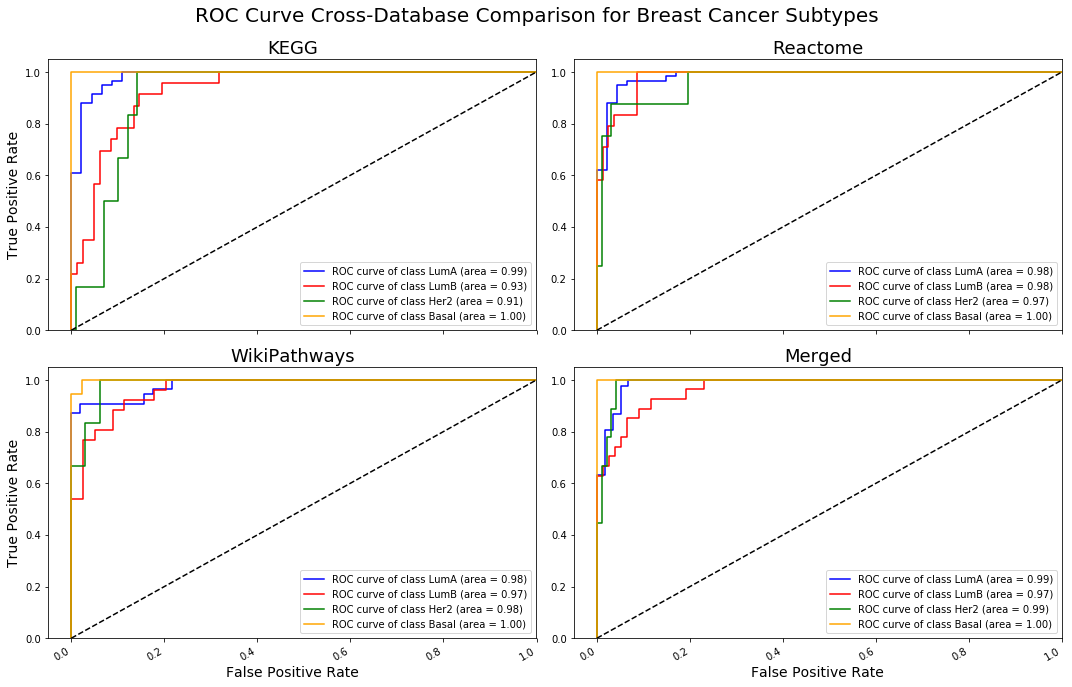

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

fig.suptitle('ROC Curve Cross-Database Comparison for Breast Cancer Subtypes', fontsize=20)

label_dict = {'LumA': 0, 'LumB': 1, 'Her2': 2, 'Basal': 3}
colors = ['blue','red','green','orange']
labels = {y:x for x,y in label_dict.items()}
label_font = {'size': 14}

plt.subplot(2, 2, 1)
for i, color in zip(range(5), colors):    
    
    plt.plot(kf[i], kt[i], color=color, 
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], kr[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate', fontdict=label_font)
plt.title('KEGG', fontsize=18)
plt.legend(loc="lower right")


plt.subplot(2, 2, 2)
for i, color in zip(range(5), colors):
    plt.plot(rf[i], rt[i], color=color, 
             label='ROC curve of class {0} (area = {1:0.2f})'''.format(labels[i], rr[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.title('Reactome', fontsize=18)
plt.legend(loc="lower right")

plt.subplot(2, 2, 3)
for i, color in zip(range(5), colors):
    plt.plot(wf[i], wt[i], color=color, 
             label='ROC curve of class {0} (area = {1:0.2f})'''.format(labels[i], wr[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate', fontdict=label_font)
plt.ylabel('True Positive Rate', fontdict=label_font)
plt.title('WikiPathways', fontsize=18)
plt.legend(loc="lower right")

plt.subplot(2,2,4)
for i, color in zip(range(5), colors):
    plt.plot(mf[i], mt[i], color=color, 
             label='ROC curve of class {0} (area = {1:0.2f})'''.format(labels[i], mr[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate', fontdict=label_font)
plt.title('Merged', fontsize=18)
plt.legend(loc="lower right")

fig.autofmt_xdate()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('roc_curves_subtype_classes.png',dpi=500)
plt.show()
